In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Load data
df = pd.read_csv('Traffic.csv')

In [4]:
# 2. Feature engineering: Binary target for 'Traffic Situation'
df['Target'] = df['Traffic Situation'].apply(lambda x: 1 if x in ['heavy', 'high'] else 0)

In [5]:
# 3. Handle missing values
def fill_missing(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    return df

df = fill_missing(df)

In [6]:
# 4. One-hot encode categorical features (except target)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['Traffic Situation']]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [7]:
# 5. Drop non-numeric columns before modeling
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
df = df.drop(non_numeric_cols, axis=1)

In [8]:
# 5b. Feature selection - remove highly correlated features
corr_matrix = df.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.95)]
df = df.drop(to_drop, axis=1)
print(f"Features after correlation removal: {df.shape[1]}")
print(f"Removed features: {to_drop}")

Features after correlation removal: 107
Removed features: ['CarCount']


* Tells us that 1 highly correlated feature (CarCount) was removed.

* Leaves 107 features.

In [9]:
# 6. Feature/target split
X = df.drop('Target', axis=1)
y = df['Target']

In [10]:
# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# 7b. Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"\nOriginal training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Resampled training set target distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Original training set shape: (2380, 106)
Resampled training set shape: (3156, 106)
Resampled training set target distribution:
Target
0    0.5
1    0.5
Name: proportion, dtype: float64


* Training set was balanced using SMOTE.

* Final training set has 50/50 class balance.

In [12]:
# 8. Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [13]:
# 9. Baseline KNN
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train_resampled)
y_pred = knn.predict(X_test_scaled)

In [14]:
# 10. Evaluation function
def evaluate(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    if model_name == "KNN (Baseline)":
        baseline_report_text = classification_report(y_true, y_pred)
        with open('knn_classification_report.txt', 'w') as f:
            f.write('=== BASELINE CLASSIFICATION REPORT ===\n')
            f.write(baseline_report_text + '\n\n')
    if model_name == "KNN (Tuned)":
        tuned_report_text = classification_report(y_true, y_pred)
        with open('knn_classification_report.txt', 'a') as f:
            f.write('=== TUNED CLASSIFICATION REPORT ===\n')
            f.write(tuned_report_text + '\n')
    return acc, prec, rec, f1

# Baseline evaluation
baseline_metrics = evaluate(y_test, y_pred, model_name="KNN (Baseline)")


=== KNN (Baseline) Evaluation ===
Accuracy: 0.8238
Precision: 0.7376
Recall: 0.7413
F1-score: 0.7395

Confusion Matrix:
[[342  53]
 [ 52 149]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       395
           1       0.74      0.74      0.74       201

    accuracy                           0.82       596
   macro avg       0.80      0.80      0.80       596
weighted avg       0.82      0.82      0.82       596



The output evaluates the baseline KNN model by displaying key metrics: accuracy, precision, recall, and F1-score, along with the confusion matrix and a classification report for each class. These results show how well the model predicts traffic conditions. The report is also saved to a text file for later comparison with the tuned model.

In [ ]:
# 11. Hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
gs = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
gs.fit(X_train_scaled, y_train_resampled)
print(f"\nBest parameters: {gs.best_params_}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


This output shows the results of hyperparameter tuning for the KNN model using grid search with 3-fold cross-validation. It tests different combinations of n_neighbors, weights, and distance metrics to find the best settings for F1-score. The printed result displays the best-performing combination of parameters, which will be used to build a more accurate tuned model.

In [ ]:
# 12. Tuned model evaluation
y_pred_tuned = gs.predict(X_test_scaled)
tuned_metrics = evaluate(y_test, y_pred_tuned, model_name="KNN (Tuned)")


=== KNN (Tuned) Evaluation ===
Accuracy: 0.8641
Precision: 0.7941
Recall: 0.8060
F1-score: 0.8000

Confusion Matrix:
[[353  42]
 [ 39 162]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       395
           1       0.79      0.81      0.80       201

    accuracy                           0.86       596
   macro avg       0.85      0.85      0.85       596
weighted avg       0.86      0.86      0.86       596



This output shows the performance of the tuned KNN model using the previously selected best parameters. It prints the accuracy, precision, recall, F1-score, the confusion matrix, and a classification report. These metrics help compare the tuned model against the baseline. The classification report is also saved and appended to the existing file for side-by-side analysis.

Cross-validation F1 scores: [0.8590604  0.82173175 0.90208668 0.95037594 0.94311377]
Mean CV F1 score: 0.8953 (+/- 0.0984)
Cross-validation Accuracy: 0.8983 (+/- 0.0865)


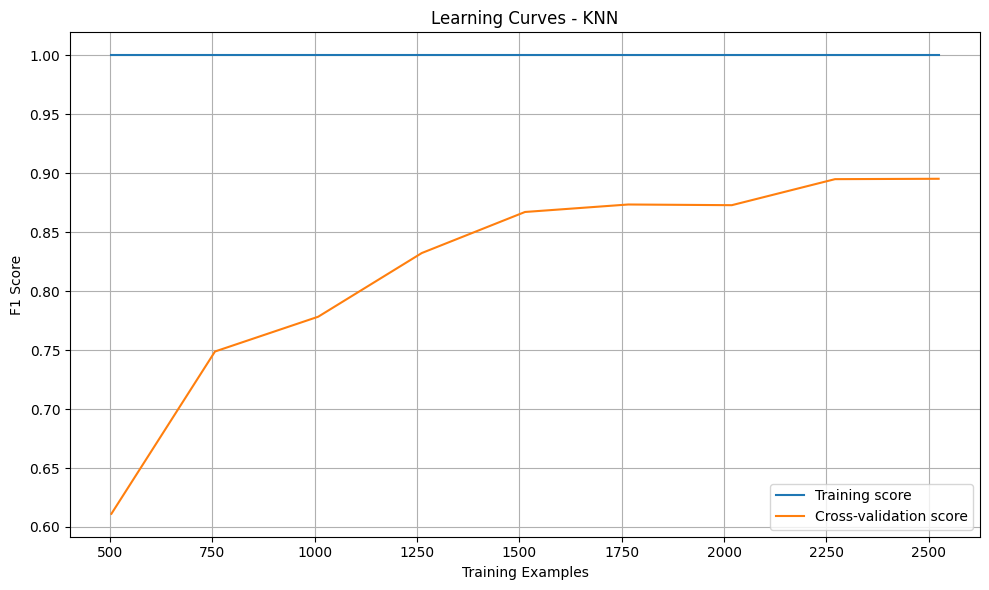

In [ ]:
# 12b. Cross-validation and model stability
cv_scores = cross_val_score(gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
cv_acc_scores = cross_val_score(gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_acc_scores.mean():.4f} (+/- {cv_acc_scores.std() * 2:.4f})")

# Learning curves
train_sizes, train_scores, val_scores = learning_curve(
    gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1'
)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('Learning Curves - KNN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('knn_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

This visualization displays the learning curves for the tuned KNN model, showing how its performance changes with different amounts of training data. Two curves are plotted: one for the training F1 score and one for the cross-validation F1 score. These curves help assess model stability and generalization. If the two lines are close together, it suggests the model performs consistently on both training and unseen data. A large gap would indicate overfitting or underfitting. The plot also shows whether adding more training data could improve performance. Overall, this helps evaluate the reliability and learning behavior of the model.

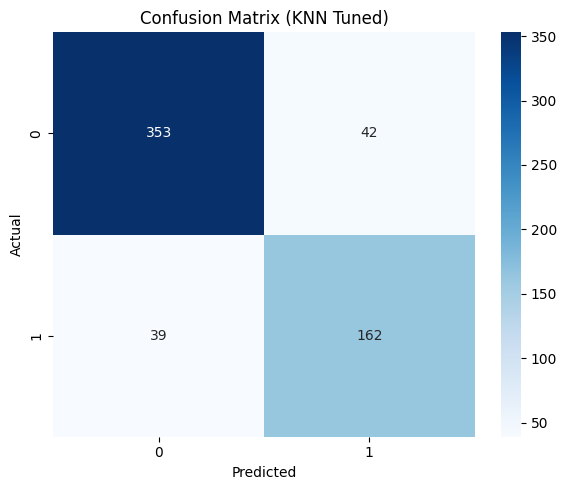

In [ ]:
# 13. Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (KNN Tuned)')
plt.tight_layout()
plt.savefig('knn_confusion_matrix.png', dpi=300)
plt.show()

This heatmap visualizes the confusion matrix for the tuned KNN model, showing how well it predicted each class. The matrix displays the number of correct and incorrect predictions: values on the diagonal represent correct classifications, while off-diagonal values indicate misclassifications. The color intensity helps highlight areas with more predictions. A darker diagonal suggests strong model performance. This visualization provides a clear and quick summary of where the model is accurate and where it may be making errors.

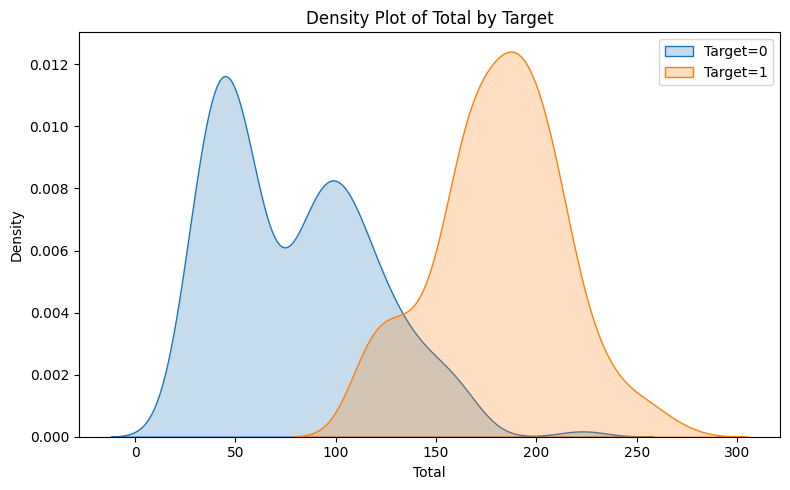


All visualizations have been saved as PNG files.

COMPARISON: BASELINE VS TUNED KNN

Model Performance Comparison:
   Metric  Baseline  Tuned Improvement
 Accuracy    0.8238 0.8641     +0.0403
Precision    0.7376 0.7941     +0.0565
   Recall    0.7413 0.8060     +0.0647
 F1-Score    0.7395 0.8000     +0.0605

Comparison table saved to 'knn_comparison.csv'

Note: KNN does not provide feature importances, so no feature importance plot is generated.

ACCURACY TABLE: BASELINE VS TUNED KNN
          Metrics Before Tuning After Tuning
Training accuracy        0.9303       1.0000
 Testing accuracy        0.8238       0.8641
          ROC AUC        0.8950       0.9403


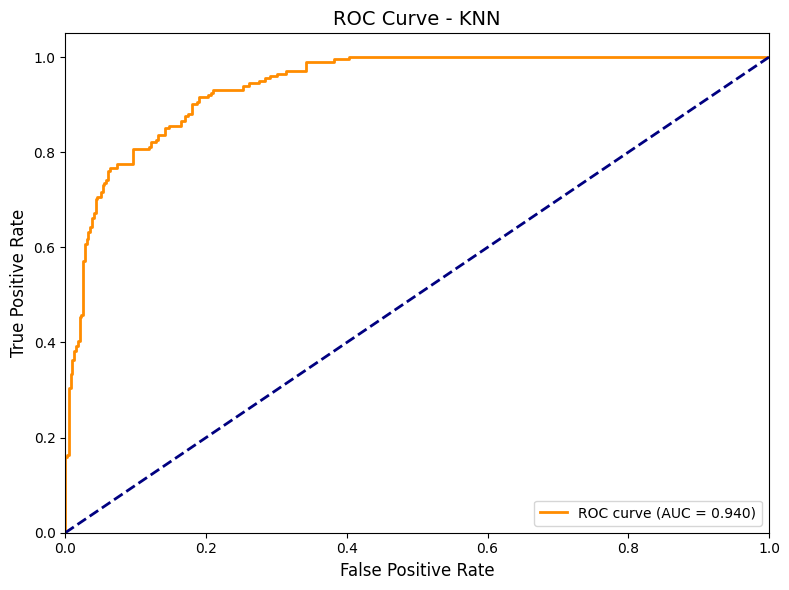

In [ ]:
# 14. Density plot for a key feature (if exists)
if 'Total' in X.columns:
    plt.figure(figsize=(8, 5))
    for label in [0, 1]:
        sns.kdeplot(X_test['Total'][y_test == label], label=f'Target={label}', fill=True)
    plt.title('Density Plot of Total by Target')
    plt.xlabel('Total')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig('knn_density_total.png', dpi=300)
    plt.show()

print("\nAll visualizations have been saved as PNG files.")

# Add comparison table after tuned model evaluation
print("\n" + "="*60)
print("COMPARISON: BASELINE VS TUNED KNN")
print("="*60)

# Get all metrics for both models
baseline_acc = accuracy_score(y_test, y_pred)
baseline_prec = precision_score(y_test, y_pred)
baseline_rec = recall_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)

tuned_acc = accuracy_score(y_test, y_pred_tuned)
tuned_prec = precision_score(y_test, y_pred_tuned)
tuned_rec = recall_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)

# Create and display comparison table
comparison_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [baseline_acc, baseline_prec, baseline_rec, baseline_f1],
    'Tuned': [tuned_acc, tuned_prec, tuned_rec, tuned_f1],
    'Improvement': [tuned_acc - baseline_acc, tuned_prec - baseline_prec,
                   tuned_rec - baseline_rec, tuned_f1 - baseline_f1]
})

# Format the table
comparison_table = comparison_table.round(4)
comparison_table['Improvement'] = comparison_table['Improvement'].apply(lambda x: f"{'+' if x >= 0 else ''}{x:.4f}")

print("\nModel Performance Comparison:")
print(comparison_table.to_string(index=False))

# Save comparison to CSV
comparison_table.to_csv('knn_comparison.csv', index=False)
print("\nComparison table saved to 'knn_comparison.csv'")

# KNN does not provide feature importances. Add a note.
print("\nNote: KNN does not provide feature importances, so no feature importance plot is generated.")

# Show training and testing accuracy table before and after tuning, including ROC AUC
train_acc_baseline = accuracy_score(y_train_resampled, knn.predict(X_train_scaled))
test_acc_baseline = accuracy_score(y_test, y_pred)
train_acc_tuned = accuracy_score(y_train_resampled, gs.predict(X_train_scaled))
test_acc_tuned = accuracy_score(y_test, y_pred_tuned)

# ROC AUC (use predict_proba)
roc_auc_baseline = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])
roc_auc_tuned = roc_auc_score(y_test, gs.predict_proba(X_test_scaled)[:, 1])

acc_table = pd.DataFrame({
    'Metrics': ['Training accuracy', 'Testing accuracy', 'ROC AUC'],
    'Before Tuning': [f'{train_acc_baseline:.4f}', f'{test_acc_baseline:.4f}', f'{roc_auc_baseline:.4f}'],
    'After Tuning': [f'{train_acc_tuned:.4f}', f'{test_acc_tuned:.4f}', f'{roc_auc_tuned:.4f}']
})
print("\n" + "="*60)
print("ACCURACY TABLE: BASELINE VS TUNED KNN")
print("="*60)
print(acc_table.to_string(index=False))

# ROC Curve Visualization for Tuned Model
knn_pred_proba = gs.predict_proba(X_test_scaled)[:, 1]
knn_roc_auc = roc_auc_score(y_test, knn_pred_proba)
fpr, tpr, _ = roc_curve(y_test, knn_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {knn_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - KNN', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('knn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

1. Density Plot of Total by Target
This plot shows how the distribution of the Total feature (sum of bike, bus, and truck counts) differs between the two classes of the target variable (0 and 1). Each curve represents one class, with filled areas showing frequency. If the curves are clearly separated, it suggests the Total feature may help in distinguishing between traffic conditions. Overlapping curves indicate limited separability.

2. Performance Comparison Table
This table compares key performance metrics — accuracy, precision, recall, and F1-score — for the baseline and tuned KNN models. It also includes an “Improvement” column to highlight how much tuning enhanced each metric. This summary helps quantify the benefit of hyperparameter optimization.

3. ROC Curve (Tuned KNN)
The ROC curve visualizes the trade-off between the true positive rate (recall) and the false positive rate at various thresholds. A curve that bows toward the top-left corner indicates strong model performance. The Area Under the Curve (AUC) value is also displayed, summarizing the model's ability to distinguish between classes — the closer to 1, the better.